# Leukemia patient classifier


## Introduction
This project focuses on classifying leukemia patients into two subgroups based on gene expression data: those with a chromosomal translocation (1) and those cytogenetically normal (-1). The dataset includes 79 patients and expression levels for 2,000 genes.

We apply supervised learning using Support Vector Machines (SVMs) to predict patient subgroups. Multiple kernel types (linear, polynomial, RBF) are tested with hyperparameter tuning via cross-validation. Additionally, we explore filtering the top 5% most variable genes to reduce noise and improve model performance.

In [137]:
import numpy as np
from matplotlib import pyplot as plt  # import subplots, cm
import sklearn.model_selection as skm
import pandas as pd
import seaborn as sns


We begin by splitting the data into training and test sets using scikit-learn, allocating 20% of the data for testing. Each model is then trained and evaluated on the training set using cross-validation to ensure robust performance estimation.

In [138]:
# Dataset
data = pd.read_csv("gene_expr.tsv", sep="\t")

# Division X and Y
X = data.drop(columns=["y", "sampleID"])  # Remove sampleID
y = data["y"]

# split in train e validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)



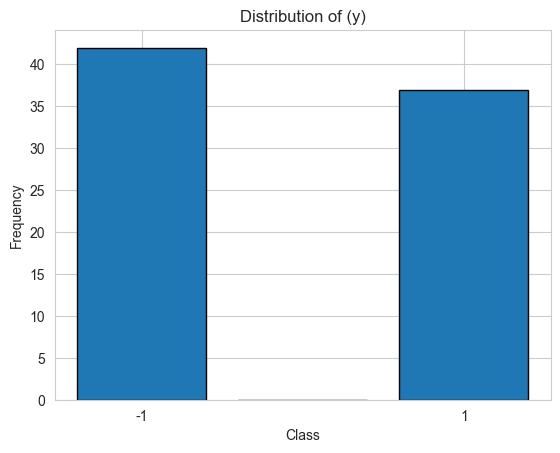

In [139]:
# Check the balanced
plt.hist(y, bins=[-1.5, -0.5, 0.5, 1.5], edgecolor='black', align='mid', rwidth=0.8)
# Etichette asse x personalizzate
plt.xticks([-1, 1], labels=['-1', '1'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of (y)')
plt.grid(True)
plt.show()

In [140]:
kfold = skm.KFold(10, random_state=0, shuffle=True)

### Linear fit
We first apply a Support Vector Machine with a linear kernel, which is often a suitable baseline for high-dimensional datasets like gene expression data. The regularization parameter C is optimized using cross-validation to balance model complexity and generalization performance.



In [141]:
# linear fit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

linear_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", probability=True, random_state=0)),
])

## hyperparameter tuning
from sklearn.model_selection import GridSearchCV
parameters = {"svm__C":[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_search_linear = GridSearchCV(
    estimator = linear_svm_clf,
    param_grid = parameters,
    scoring= "accuracy",
    n_jobs=-1,
    refit="accuracy",
    cv= kfold,
)
grid_search_linear.fit(X_train, y_train)
svm_linear_model = grid_search_linear.best_estimator_.named_steps["svm"]


**Model description**
The table below summarizes the main characteristics of the best-performing linear SVM model (`svm_linear_model`):

In [142]:
## Metric evaluation
import pandas as pd

# Estrai i valori desiderati
n_support_vectors = svm_linear_model.support_vectors_.shape[0]
support_per_class = svm_linear_model.n_support_
best_score = grid_search_linear.best_score_
best_params = grid_search_linear.best_params_

# Crea un dizionario per la tabella
svm_summary = {
    "Metric": [
        "Total support vectors",
        "Support vectors per class",
        "Best CV score (accuracy)",
        "Best hyperparameters"
    ],
    "Value": [
        n_support_vectors,
        support_per_class.tolist(),
        round(best_score, 3),
        str(best_params)
    ]
}

# Converti in DataFrame
svm_df = pd.DataFrame(svm_summary)

# Visualizza
svm_df


,Metric,Value
0,Total support vectors,57
1,Support vectors per class,"[30, 27]"
2,Best CV score (accuracy),0.81
3,Best hyperparameters,{'svm__C': 0.001}


In [143]:
## Predictions
y_pred_linear = grid_search_linear.predict(X_test)
y_pred_proba_linear = grid_search_linear.predict_proba(X_test)[:, 1]

In [144]:
## Evaluation
from sklearn.metrics import confusion_matrix
cm_svm_linear_model = confusion_matrix(y_test, y_pred_linear)

### Polynomail kernel
We then extend the linear model by applying a polynomial kernel, which allows the SVM to capture non-linear relationships between gene expression features. Both the regularization parameter C and the polynomial degree are tuned via cross-validation.

In [145]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

polynoaml_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="poly", probability=True, random_state=0)),
])

## hyperparameter tuning
from sklearn.model_selection import GridSearchCV
parameters = {"svm__C":[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "svm__degree":[1,2,3,4,5,6]}

grid_search_poly = GridSearchCV(
    estimator = polynoaml_svm_clf,
    param_grid= parameters,
    scoring="accuracy",
    n_jobs=-1,
    refit="accuracy",
    cv= kfold,
)
grid_search_poly.fit(X_train, y_train)
svm_polynomial_model = grid_search_poly.best_estimator_.named_steps["svm"]


In [146]:
## Metric evaluation
n_support_vectors = svm_polynomial_model.support_vectors_.shape[0]
support_per_class = svm_polynomial_model.n_support_
best_score = grid_search_poly.best_score_
best_params = grid_search_poly.best_params_

# Crea un dizionario per la tabella
svm_summary = {
    "Metric": [
        "Total support vectors",
        "Support vectors per class",
        "Best CV score (accuracy)",
        "Best hyperparameters"
    ],
    "Value": [
        n_support_vectors,
        support_per_class.tolist(),
        round(best_score, 3),
        str(best_params)
    ]
}

# Converti in DataFrame
svm_df = pd.DataFrame(svm_summary)

# Visualizza
svm_df

,Metric,Value
0,Total support vectors,55
1,Support vectors per class,"[29, 26]"
2,Best CV score (accuracy),0.743
3,Best hyperparameters,"{'svm__C': 10, 'svm__degree': 1}"


In [147]:
## Predictions
y_pred_poly = grid_search_poly.predict(X_test)
y_pred_proba_poly = grid_search_poly.predict_proba(X_test)[:, 1]

In [148]:
## Evaluation
from sklearn.metrics import confusion_matrix
cm_svm_polynomial_model = confusion_matrix(y_test, y_pred_poly)

### Gaussian kernel
Finally, we apply a Gaussian (RBF) kernel SVM, which is well suited for capturing complex and non-linear patterns in the data. We tune both the regularization parameter C and the kernel coefficient gamma using cross-validation.

In [149]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

gaussian_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True, random_state=0)),
])

## hyperparameter tuning
from sklearn.model_selection import GridSearchCV
parameters = {"svm__C":[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "svm__gamma": [0.0001, 0.001, 0.01, 0.1, 1, 10]}

grid_search_gaussian = GridSearchCV(
    estimator = gaussian_svm_clf,
    param_grid= parameters,
    scoring="accuracy",
    n_jobs=-1,
    refit="accuracy",
    cv=kfold,
)
grid_search_gaussian.fit(X_train, y_train)
svm_gaussian_model = grid_search_gaussian.best_estimator_.named_steps["svm"]

In [150]:
## Metric evaluation
n_support_vectors = svm_gaussian_model.support_vectors_.shape[0]
support_per_class = svm_gaussian_model.n_support_
best_score = grid_search_gaussian.best_score_
best_params = grid_search_gaussian.best_params_

# Crea un dizionario per la tabella
svm_summary = {
    "Metric": [
        "Total support vectors",
        "Support vectors per class",
        "Best CV score (accuracy)",
        "Best hyperparameters"
    ],
    "Value": [
        n_support_vectors,
        support_per_class.tolist(),
        round(best_score, 3),
        str(best_params)
    ]
}

# Converti in DataFrame
svm_df = pd.DataFrame(svm_summary)

# Visualizza
svm_df

,Metric,Value
0,Total support vectors,62
1,Support vectors per class,"[32, 30]"
2,Best CV score (accuracy),0.757
3,Best hyperparameters,"{'svm__C': 10, 'svm__gamma': 0.0001}"


In [151]:
## Predictions
y_pred_rbf = grid_search_gaussian.predict(X_test)
y_pred_proba_rbf = grid_search_gaussian.predict_proba(X_test)[:, 1]

In [152]:
from sklearn.metrics import confusion_matrix
cm_svm_gaussian_model = confusion_matrix(y_test, y_pred_rbf)


### Comparison of the models


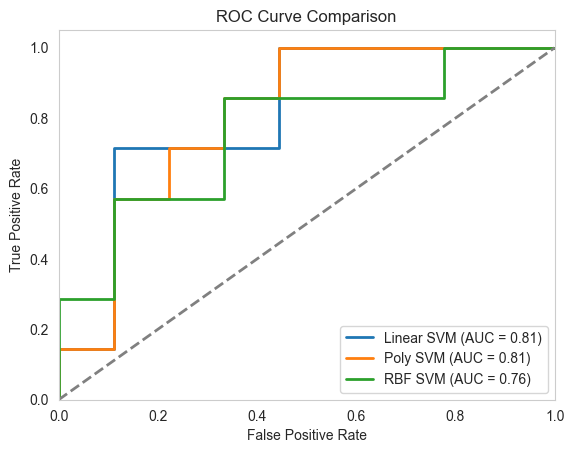

In [153]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcolo delle curve ROC e AUC
fpr_linear, tpr_linear, _ = roc_curve(y_test, y_pred_proba_linear)
roc_auc_linear = auc(fpr_linear, tpr_linear)

fpr_poly, tpr_poly, _ = roc_curve(y_test, y_pred_proba_poly)
roc_auc_poly = auc(fpr_poly, tpr_poly)

fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_pred_proba_rbf)
roc_auc_rbf = auc(fpr_rbf, tpr_rbf)

# Plot ROC curve sovrapposte
plt.figure()
plt.plot(fpr_linear, tpr_linear, lw=2, label=f'Linear SVM (AUC = {roc_auc_linear:.2f})')
plt.plot(fpr_poly, tpr_poly, lw=2, label=f'Poly SVM (AUC = {roc_auc_poly:.2f})')
plt.plot(fpr_rbf, tpr_rbf, lw=2, label=f'RBF SVM (AUC = {roc_auc_rbf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # random classifier line

# Layout
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [154]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import pandas as pd

# Calcolo delle metriche per ciascun modello
acc_linear = accuracy_score(y_test, y_pred_linear)
acc_poly = accuracy_score(y_test, y_pred_poly)
acc_rbf = accuracy_score(y_test, y_pred_rbf)

roc_linear = roc_auc_score(y_test, y_pred_proba_linear)
roc_poly = roc_auc_score(y_test, y_pred_proba_poly)
roc_rbf = roc_auc_score(y_test, y_pred_proba_rbf)

precision_linear = precision_score(y_test, y_pred_linear)
precision_poly = precision_score(y_test, y_pred_poly)
precision_rbf = precision_score(y_test, y_pred_rbf)

recall_linear = recall_score(y_test, y_pred_linear)
recall_poly = recall_score(y_test, y_pred_poly)
recall_rbf = recall_score(y_test, y_pred_rbf)

f1_linear = f1_score(y_test, y_pred_linear)
f1_poly = f1_score(y_test, y_pred_poly)
f1_rbf = f1_score(y_test, y_pred_rbf)

# Creazione della tabella
results_df = pd.DataFrame({
    "Model": ["Linear SVM", "Poly SVM", "RBF SVM"],
    "Accuracy": [acc_linear, acc_poly, acc_rbf],
    "ROC AUC": [roc_linear, roc_poly, roc_rbf],
    "Precision": [precision_linear, precision_poly, precision_rbf],
    "Recall": [recall_linear, recall_poly, recall_rbf],
    "F1-score": [f1_linear, f1_poly, f1_rbf]
})

# Visualizza la tabella
df = pd.DataFrame(results_df)
df




,Model,Accuracy,ROC AUC,Precision,Recall,F1-score
0,Linear SVM,0.7500,0.809524,0.800000,0.571429,0.666667
1,Poly SVM,0.6875,0.809524,0.666667,0.571429,0.615385
2,RBF SVM,0.6875,0.761905,0.666667,0.571429,0.615385


From the metrics and from the ROC-curve it seems that the best model is the RBF SV

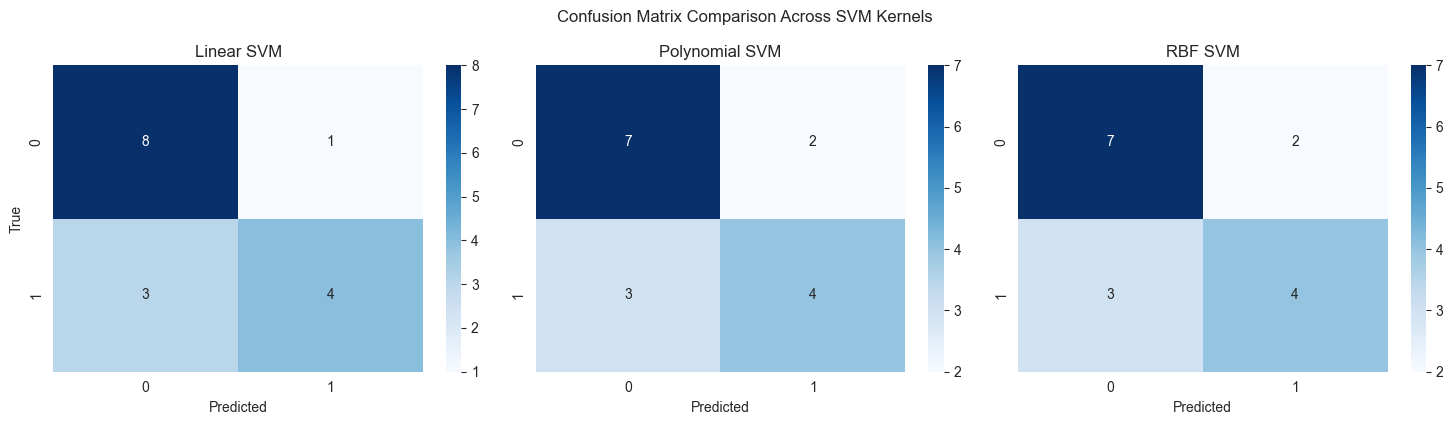

In [155]:
# Comparison throught Confusion matrix
plt.figure(figsize=(15, 4))

# Linear SVM
plt.subplot(1, 3, 1)  # 1 riga, 3 colonne, posizione 1
sns.heatmap(cm_svm_linear_model, annot=True, fmt='d', cmap='Blues')
plt.title("Linear SVM")
plt.xlabel("Predicted")
plt.ylabel("True")

# Polynomial SVM
plt.subplot(1, 3, 2)  # 1 riga, 3 colonne, posizione 2
sns.heatmap(cm_svm_polynomial_model, annot=True, fmt='d', cmap='Blues')
plt.title("Polynomial SVM")
plt.xlabel("Predicted")
plt.ylabel("")

# Gaussian/RBF SVM
plt.subplot(1, 3, 3)  # 1 riga, 3 colonne, posizione 3
sns.heatmap(cm_svm_gaussian_model, annot=True, fmt='d', cmap='Blues')
plt.title("RBF SVM")
plt.xlabel("Predicted")
plt.ylabel("")

# Layout
plt.tight_layout()
plt.suptitle("Confusion Matrix Comparison Across SVM Kernels", y=1.05)
plt.show()



#### Threshold set

Best threshold: 0.459


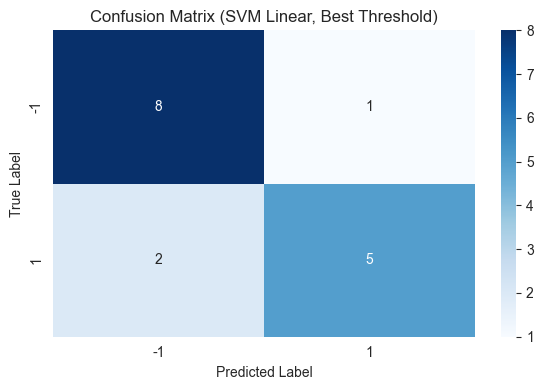

In [156]:
# Probabilità predette per la classe positiva
y_pred_proba_linear = grid_search_linear.predict_proba(X_test)[:, 1]

# Calcolo fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_linear)

# Youden's J statistic
best_threshold = thresholds[np.argmax(np.abs(fpr - tpr))]

print(f"Best threshold: {best_threshold:.3f}")

# Riclassificazione con soglia ottimale
y_pred_linear_BT = np.where(y_pred_proba_linear >= best_threshold, 1, -1)

cm_svm_linear_BT = confusion_matrix(y_test, y_pred_linear_BT)
cm_svm_linear_BT

# plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm_linear_BT, annot=True, fmt='d', cmap='Blues',
            xticklabels=[-1, 1], yticklabels=[-1, 1])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SVM Linear, Best Threshold)')
plt.tight_layout()
plt.show()

In [157]:
# Calcolo metriche
acc = accuracy_score(y_test, y_pred_linear_BT)
prec = precision_score(y_test, y_pred_linear_BT, pos_label=1)
rec = recall_score(y_test, y_pred_linear_BT, pos_label=1)
f1 = f1_score(y_test, y_pred_linear_BT, pos_label=1)

# Creazione tabella con pandas
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
    "New_Score": [acc, prec, rec, f1],
    "Old_score": [acc_linear, precision_linear, recall_linear, f1_linear]
})

metrics_df

,Metric,New_Score,Old_score
0,Accuracy,0.812500,0.750000
1,Precision,0.833333,0.800000
2,Recall,0.714286,0.571429
3,F1-score,0.769231,0.666667


## Variance deletion
A popular approach in gene expression analysis is to keep only the most variable genes for downstream
analysis. Since most of the 2K genes have low expression or do not vary much across the experiments,
this step usually minimizes the contribution of noise. Select then only genes whose standard deviation
is among the top 5% and repeat the analyses performed in the previous task on the filtered data set.

In [158]:
# Compute standard deviation of genes on X_train
stds = X_train.std(axis=0)
# Select top 5% most variable genes
top_genes = stds.sort_values(ascending=False).head(int(0.05 * len(stds))).index

# Filter both train and test on these genes
X_train_filtered = X_train[top_genes]
X_test_filtered = X_test[top_genes]


In [159]:
len(top_genes)

100

### Linear

In [160]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
linear_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", probability=True, random_state=0)),
])

## hyperparameter tuning
from sklearn.model_selection import GridSearchCV
parameters = {"svm__C":[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_search_linear_c = GridSearchCV(
    estimator = linear_svm_clf,
    param_grid = parameters,
    scoring= "accuracy",
    n_jobs=-1,
    refit="accuracy",
    cv= kfold,
)
grid_search_linear_c.fit(X_train_filtered, y_train)
svm_linear_model_c = grid_search_linear_c.best_estimator_.named_steps["svm"]

In [161]:
# Metric evaluation
n_support_vectors = svm_linear_model_c.support_vectors_.shape[0]
support_per_class = svm_linear_model_c.n_support_
best_score = grid_search_linear_c.best_score_
best_params = grid_search_linear_c.best_params_

# Crea un dizionario per la tabella
svm_summary = {
    "Metric": [
        "Total support vectors",
        "Support vectors per class",
        "Best CV score (accuracy)",
        "Best hyperparameters"
    ],
    "Value": [
        n_support_vectors,
        support_per_class.tolist(),
        round(best_score, 3),
        str(best_params)
    ]
}

# Converti in DataFrame
svm_df = pd.DataFrame(svm_summary)

# Visualizza
svm_df

,Metric,Value
0,Total support vectors,35
1,Support vectors per class,"[16, 19]"
2,Best CV score (accuracy),0.826
3,Best hyperparameters,{'svm__C': 0.1}


In [162]:
## Predictions
y_pred_linear_c = grid_search_linear_c.predict(X_test_filtered)
y_pred_proba_linear_c = grid_search_linear_c.predict_proba(X_test_filtered)[:, 1]

In [163]:
## Evaluation
from sklearn.metrics import confusion_matrix
cm_grid_search_linear_c = confusion_matrix(y_test, y_pred_linear_c)

### Polynomial

In [164]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

polynoaml_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="poly", probability=True, random_state=0)),
])

## hyperparameter tuning
from sklearn.model_selection import GridSearchCV

parameters = {"svm__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "svm__degree": [1, 2, 3, 4, 5, 6]}

grid_search_poly_c = GridSearchCV(
    estimator=polynoaml_svm_clf,
    param_grid=parameters,
    scoring="accuracy",
    n_jobs=-1,
    refit="accuracy",
    cv=kfold,
)
grid_search_poly_c.fit(X_train_filtered, y_train)
svm_poly_model_c = grid_search_poly_c.best_estimator_.named_steps["svm"]

In [165]:
# Metric evaluation
n_support_vectors = svm_poly_model_c.support_vectors_.shape[0]
support_per_class = svm_poly_model_c.n_support_
best_score = grid_search_poly_c.best_score_
best_params = grid_search_poly_c.best_params_

# Crea un dizionario per la tabella
svm_summary = {
    "Metric": [
        "Total support vectors",
        "Support vectors per class",
        "Best CV score (accuracy)",
        "Best hyperparameters"
    ],
    "Value": [
        n_support_vectors,
        support_per_class.tolist(),
        round(best_score, 3),
        str(best_params)
    ]
}

# Converti in DataFrame
svm_df = pd.DataFrame(svm_summary)

# Visualizza
svm_df

,Metric,Value
0,Total support vectors,35
1,Support vectors per class,"[16, 19]"
2,Best CV score (accuracy),0.826
3,Best hyperparameters,"{'svm__C': 10, 'svm__degree': 1}"


In [166]:
## Predictions
y_pred_poly_c = grid_search_poly_c.predict(X_test_filtered)
y_pred_proba_poly_c = grid_search_poly_c.predict_proba(X_test_filtered)[:, 1]


In [167]:
## Evaluation
from sklearn.metrics import confusion_matrix
cm_svm_poly_model_c = confusion_matrix(y_test, y_pred_poly_c)


### Gaussian

In [168]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

gaussian_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True, random_state=0)),
])

## hyperparameter tuning
from sklearn.model_selection import GridSearchCV

parameters = {"svm__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "svm__gamma": [0.0001, 0.001, 0.01, 0.1, 1, 10]}

grid_search_gaussian_c = GridSearchCV(
    estimator=gaussian_svm_clf,
    param_grid=parameters,
    scoring="accuracy",
    n_jobs=-1,
    refit="accuracy",
    cv=kfold,
)
grid_search_gaussian_c.fit(X_train_filtered, y_train)
svm_gaussian_model_c = grid_search_gaussian_c.best_estimator_.named_steps["svm"]


In [169]:
# Metric evaluation
n_support_vectors = svm_gaussian_model_c.support_vectors_.shape[0]
support_per_class = svm_gaussian_model_c.n_support_
best_score = grid_search_gaussian_c.best_score_
best_params = grid_search_gaussian_c.best_params_

# Crea un dizionario per la tabella
svm_summary = {
    "Metric": [
        "Total support vectors",
        "Support vectors per class",
        "Best CV score (accuracy)",
        "Best hyperparameters"
    ],
    "Value": [
        n_support_vectors,
        support_per_class.tolist(),
        round(best_score, 3),
        str(best_params)
    ]
}

# Converti in DataFrame
svm_df = pd.DataFrame(svm_summary)

# Visualizza
svm_df

,Metric,Value
0,Total support vectors,42
1,Support vectors per class,"[22, 20]"
2,Best CV score (accuracy),0.871
3,Best hyperparameters,"{'svm__C': 10, 'svm__gamma': 0.001}"


In [170]:
## Predictions
y_pred_rbf_c = grid_search_gaussian_c.predict(X_test_filtered)
y_pred_proba_rbf_c = grid_search_gaussian_c.predict_proba(X_test_filtered)[:, 1]

In [171]:
## Evaluation
from sklearn.metrics import confusion_matrix
cm_svm_gaussian_model_c = confusion_matrix(y_test, y_pred_rbf_c)


#### Comparison model

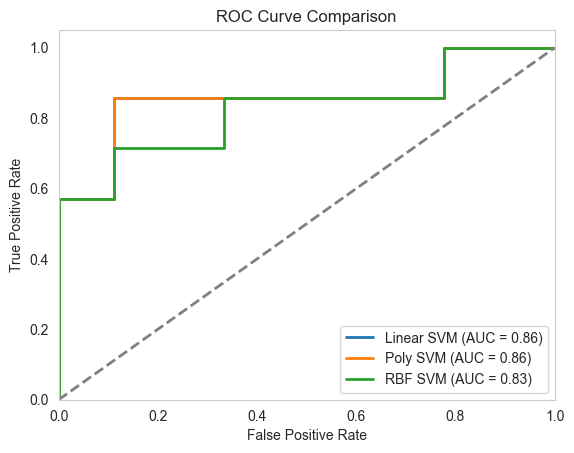

In [172]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcolo delle curve ROC e AUC
fpr_linear, tpr_linear, _ = roc_curve(y_test, y_pred_proba_linear_c)
roc_auc_linear = auc(fpr_linear, tpr_linear)

fpr_poly, tpr_poly, _ = roc_curve(y_test, y_pred_proba_poly_c)
roc_auc_poly = auc(fpr_poly, tpr_poly)

fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_pred_proba_rbf_c)
roc_auc_rbf = auc(fpr_rbf, tpr_rbf)

# Plot ROC curve sovrapposte
plt.figure()
plt.plot(fpr_linear, tpr_linear, lw=2, label=f'Linear SVM (AUC = {roc_auc_linear:.2f})')
plt.plot(fpr_poly, tpr_poly, lw=2, label=f'Poly SVM (AUC = {roc_auc_poly:.2f})')
plt.plot(fpr_rbf, tpr_rbf, lw=2, label=f'RBF SVM (AUC = {roc_auc_rbf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # random classifier line

# Layout
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [173]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import pandas as pd

# Calcolo delle metriche per ciascun modello
acc_linear = accuracy_score(y_test, y_pred_linear_c)
acc_poly = accuracy_score(y_test, y_pred_poly_c)
acc_rbf = accuracy_score(y_test, y_pred_rbf_c)

roc_linear = roc_auc_score(y_test, y_pred_proba_linear_c)
roc_poly = roc_auc_score(y_test, y_pred_proba_poly_c)
roc_rbf = roc_auc_score(y_test, y_pred_proba_rbf_c)

precision_linear = precision_score(y_test, y_pred_linear_c)
precision_poly = precision_score(y_test, y_pred_poly_c)
precision_rbf = precision_score(y_test, y_pred_rbf_c)

recall_linear = recall_score(y_test, y_pred_linear_c)
recall_poly = recall_score(y_test, y_pred_poly_c)
recall_rbf = recall_score(y_test, y_pred_rbf_c)

f1_linear = f1_score(y_test, y_pred_linear_c)
f1_poly = f1_score(y_test, y_pred_poly_c)
f1_rbf = f1_score(y_test, y_pred_rbf_c)

# Creazione della tabella
results_df = pd.DataFrame({
    "Model": ["Linear SVM", "Poly SVM", "RBF SVM"],
    "Accuracy": [acc_linear, acc_poly, acc_rbf],
    "ROC AUC": [roc_linear, roc_poly, roc_rbf],
    "Precision": [precision_linear, precision_poly, precision_rbf],
    "Recall": [recall_linear, recall_poly, recall_rbf],
    "F1-score": [f1_linear, f1_poly, f1_rbf]
})

# Visualizza la tabella
pd.DataFrame(results_df)


,Model,Accuracy,ROC AUC,Precision,Recall,F1-score
0,Linear SVM,0.7500,0.857143,0.8,0.571429,0.666667
1,Poly SVM,0.7500,0.857143,0.8,0.571429,0.666667
2,RBF SVM,0.8125,0.825397,1.0,0.571429,0.727273


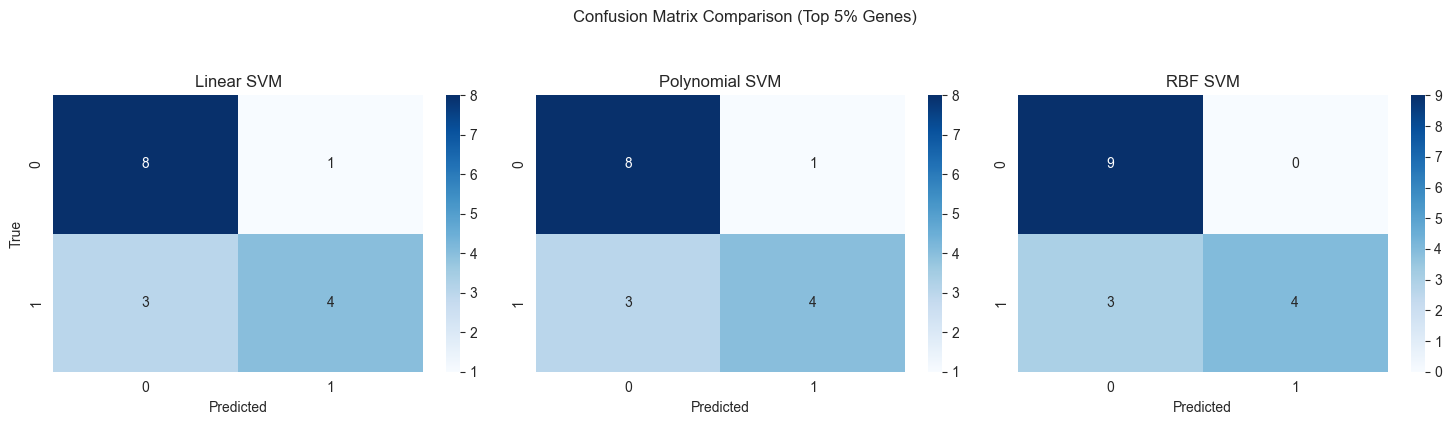

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 4))

# Linear SVM
plt.subplot(1, 3, 1)
sns.heatmap(cm_grid_search_linear_c, annot=True, fmt='d', cmap='Blues')
plt.title("Linear SVM")
plt.xlabel("Predicted")
plt.ylabel("True")

# Polynomial SVM
plt.subplot(1, 3, 2)
sns.heatmap(cm_svm_poly_model_c, annot=True, fmt='d', cmap='Blues')
plt.title("Polynomial SVM")
plt.xlabel("Predicted")
plt.ylabel("")

# RBF/Gaussian SVM
plt.subplot(1, 3, 3)
sns.heatmap(cm_svm_gaussian_model_c, annot=True, fmt='d', cmap='Blues')
plt.title("RBF SVM")
plt.xlabel("Predicted")
plt.ylabel("")

plt.suptitle("Confusion Matrix Comparison (Top 5% Genes)", y=1.05)
plt.tight_layout()
plt.show()


#### Best Threshold

Best threshold: 0.423


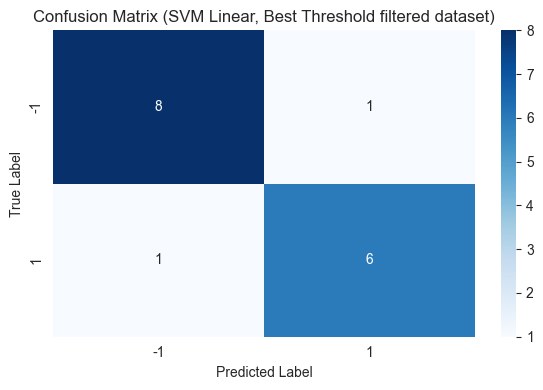

In [181]:
# Probabilità predette per la classe positiva
y_pred_proba_linear_c = grid_search_linear_c.predict_proba(X_test_filtered)[:, 1]

# Calcolo fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_linear_c)

# Youden's J statistic
best_threshold = thresholds[np.argmax(np.abs(fpr - tpr))]

print(f"Best threshold: {best_threshold:.3f}")

# Riclassificazione con soglia ottimale
y_pred_linear_BT_c = np.where(y_pred_proba_linear_c >= best_threshold, 1, -1)

cm_y_pred_linear_BT_c = confusion_matrix(y_test, y_pred_linear_BT_c)
cm_y_pred_linear_BT_c

# plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm_y_pred_linear_BT_c, annot=True, fmt='d', cmap='Blues',
            xticklabels=[-1, 1], yticklabels=[-1, 1])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SVM Linear, Best Threshold filtered dataset)')
plt.tight_layout()
plt.show()

In [182]:
# Calcolo metriche
acc = accuracy_score(y_test, y_pred_linear_BT_c)
prec = precision_score(y_test, y_pred_linear_BT_c, pos_label=1)
rec = recall_score(y_test, y_pred_linear_BT_c, pos_label=1)
f1 = f1_score(y_test, y_pred_linear_BT_c, pos_label=1)

# Creazione tabella con pandas
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
    "New_Score": [acc, prec, rec, f1],
    "Old_score": [acc_linear, precision_linear, recall_linear, f1_linear]
})

metrics_df

,Metric,New_Score,Old_score
0,Accuracy,0.875000,0.750000
1,Precision,0.857143,0.800000
2,Recall,0.857143,0.571429
3,F1-score,0.857143,0.666667


In [183]:
# Probabilità predette per la classe positiva
y_pred_proba_gaussian_c = grid_search_gaussian_c.predict_proba(X_test_filtered)[:, 1]

# Calcolo fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_gaussian_c)

# Youden's J statistic
best_threshold = thresholds[np.argmax(np.abs(fpr - tpr))]

print(f"Best threshold: {best_threshold:.3f}")

# Riclassificazione con soglia ottimale
y_pred_gaussian_BT_c = np.where(y_pred_proba_gaussian_c >= best_threshold, 1, -1)

cm_y_pred_gaussian_BT_c = confusion_matrix(y_test, y_pred_linear_BT_c)
cm_y_pred_gaussian_BT_c

Best threshold: 0.411


array([[8, 1],
       [1, 6]])

In [185]:
acc = accuracy_score(y_test, y_pred_gaussian_BT_c)
prec = precision_score(y_test, y_pred_gaussian_BT_c, pos_label=1)
rec = recall_score(y_test, y_pred_gaussian_BT_c, pos_label=1)
f1 = f1_score(y_test, y_pred_gaussian_BT_c, pos_label=1)

# Creazione tabella con pandas
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
    "New_Score": [acc, prec, rec, f1],
    "Old_score": [acc_rbf, precision_rbf, recall_rbf, f1_rbf]
})

metrics_df

,Metric,New_Score,Old_score
0,Accuracy,0.812500,0.812500
1,Precision,0.833333,1.000000
2,Recall,0.714286,0.571429
3,F1-score,0.769231,0.727273
